In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# <span style="color:#800000">PART 1: EPIDEMIC PROCESS ON A SOCIAL NETWORK (8 points)

## <span style="color:#800000">1.1 - Consider either a synthetic Barabasi-Albert graph or a real social network (e.g., from the <a href="http://snap.stanford.edu/" style="color:#cc0000">SNAP</a> or <a href="http://konect.uni-koblenz.de/" style="color:#cc0000">Konect repositories</a>). If the chosen graph has multiple disconnected components, select the largest connected component. Make sure the graph has at least a few thousand nodes. Compute and plot the degree distribution.

### Let's choose  the facebook network from SNAP. It is undirected with 4039 nodes and 88234 edges.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
G=nx.read_adjlist("D:/DataScience/DE/HW01/facebook_combined.txt.gz")
#G = nx.barabasi_albert_graph(1000,2)
print('Connected:',nx.is_connected(G))
print('n. of nodes:',len(G.nodes()))
print('n. of edges:',len(G.edges()))
print('Directed:',G.is_directed())

Connected: True
n. of nodes: 4039
n. of edges: 88234
Directed: False


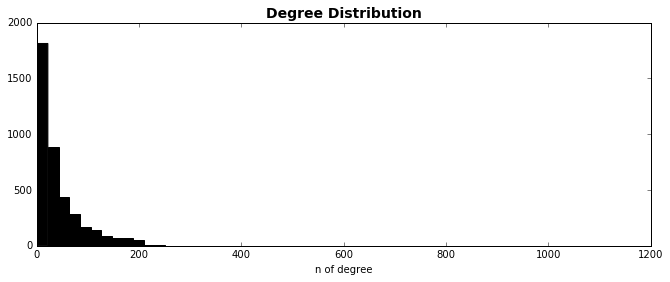

In [4]:
plt.figure(figsize=(11, 4))
plt.hist(list(G.degree().values()),50, color = (0,0,0,1))
plt.title('Degree Distribution', fontsize=14, fontweight='bold')
plt.xlabel('n of degree')
plt.show()

## <span style="color:#800000">1.2 - Set up a simulation of an SIR epidemic process on the graph. Start the epidemic from a randomly chosen node. Choose values of model parameters $\beta$ and $\mu$ that allow the epidemic to take off with high probability, reaching most of the nodes.

### In general, if we want to increase $\frac{di}{dt}$, we need to increase $\beta$ (the probability to infect a susceptible neighbor) and to decrease $\mu$ (the probability that a given infected node turns in a recovered node).  We also need $\mu$ not to be too small to guarantee all the infected nodes to turn in recovered (the model stops only when there are no more infected nodes).

In [5]:
class SIRSimulator:
    def __init__(self,graph,beta=0.25,mu=0.05):
        self.g=graph
        self.BETA=beta
        self.MU=mu
        
    def run(self, seed=[],num_steps=1):
        if not len(seed):
            seed = [np.random.choice(self.g.nodes())]
        I_set=set(seed)
        S_set=set(self.g.nodes()).difference(I_set)
        R_set=set()
        t=0
        
        StoI_set= set(seed)
        ItoR_set=set()
        while True:
            if t%num_steps==0:
                yield{'t':t, "S": S_set, "I":I_set, 'R':R_set,
                      "S->I":StoI_set,"I->R":ItoR_set}
            if not len(I_set):
                break
            
            StoI_set= set()
            ItoR_set= set()
            
            for i in set(I_set):
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA :
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
            t+=1

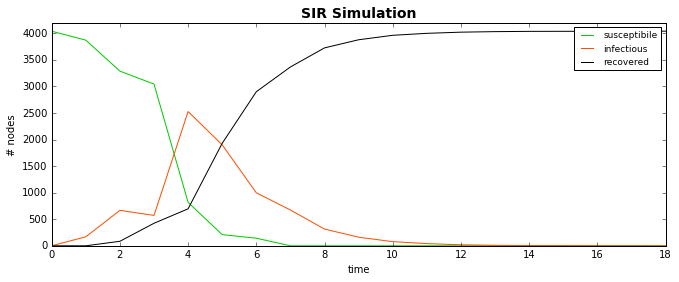

In [6]:
plt.figure(figsize=(11, 4))
beta = 0.99
mu = 0.5
SIR=SIRSimulator(G,beta,mu)  
results = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIR.run()]
susceptibles = [s for s,i,r in results]
infectious = [i for s,i,r in results]
recovered = [r for s,i,r in results]

plt.plot(susceptibles, color = (0,.8,0,1), linewidth = 1)
plt.plot(infectious, color = (1,.3,0,1), linewidth = 1)
plt.plot(recovered, color = (0,0,0,1), linewidth = 1)

plt.title('SIR Simulation', fontsize=14, fontweight='bold')
plt.xlabel('time')
plt.ylabel('# nodes')
plt.legend(['susceptibile','infectious','recovered'], prop={'size': 9})
plt.ylim(0,4200)
plt.show()


## <span style="color:#800000">1.3 -  Plot epidemic curves for multiple stochastic realizations of the epidemic. Compute the probability distribution of the overall attack rate (number of recovered nodes at the end of the simulation / total number of nodes) and the probability distribution of peak times for the epidemic. Display these distributions using boxplots.

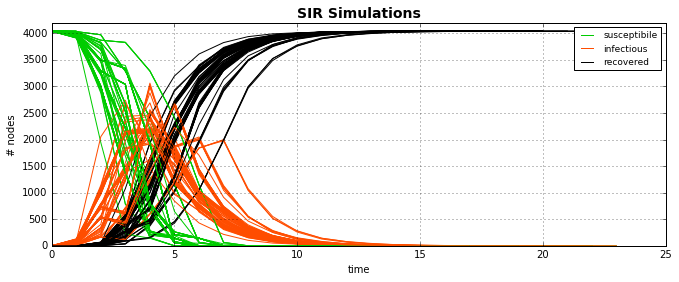

In [7]:
n = 100
overall_attack_rate = []
peak_time = []
plt.figure(figsize=(11, 4))
plt.title('SIR Simulations', fontsize=14, fontweight='bold')
# Let's plot only the first 10 simulations
for i in range(n):
    SIR=SIRSimulator(G,beta,mu)
    results = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIR.run()]
    infectious = [i for s,i,r in results]
    susceptibles = [s for s,i,r in results]
    recovered = [r for s,i,r in results]
    peak_time += [np.argmax(infectious)]
    n_recovered_nodes = results[-1][-1]
    overall_attack_rate += [n_recovered_nodes/len(G.nodes())]
    if i<100:
        plt.plot(susceptibles, color = (0,.8,0,1), linewidth = 1)
        plt.plot(infectious, color = (1,.3,0,1), linewidth = 1)
        plt.plot(recovered, color = (0,0,0,1), linewidth = 1)
        
        plt.xlabel('time')
        plt.ylabel('# nodes')
        plt.legend(['susceptibile','infectious','recovered'], prop={'size': 9})
        plt.ylim(0,4200)
plt.grid()
plt.show()

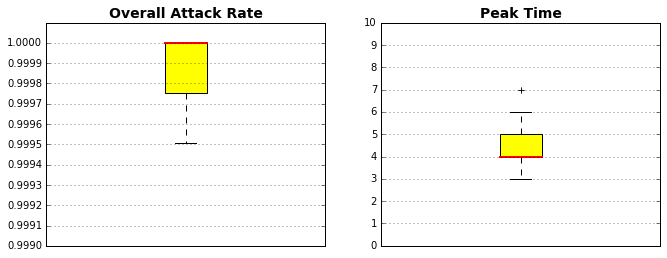

OVERALL ATTACK RATE min: 4037 recovered, over 4039
PEAK TIME min: 3 max: 7


In [8]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
bp1 = plt.boxplot(overall_attack_rate, patch_artist = True)
plt.setp(bp1['boxes'], color='black')
plt.setp(bp1['whiskers'], color='black')
plt.setp(bp1['medians'], color='red', linewidth = 2)
plt.setp(bp1['fliers'], color='black')
plt.setp(bp1['caps'], color='black')
bp1['boxes'][0].set_facecolor((1,1,0,1))
plt.title('Overall Attack Rate', fontsize=14, fontweight='bold')
plt.ylim(0.999,1.0001)
plt.yticks(np.array(range(11))*0.0001+0.999)
plt.xticks([])
plt.grid()

plt.subplot(122)
bp2 = plt.boxplot(peak_time, patch_artist = True)
plt.setp(bp2['boxes'], color='black')
plt.setp(bp2['whiskers'], color='black')
plt.setp(bp2['medians'], color='red', linewidth = 2)
plt.setp(bp2['fliers'], color='black')
plt.setp(bp2['caps'], color='black')
bp2['boxes'][0].set_facecolor((1,1,0,1))
plt.title('Peak Time', fontsize=14, fontweight='bold')
plt.ylim(0,10)
plt.yticks(np.array(range(11)))
plt.xticks([])
plt.grid()
plt.show()
print('OVERALL ATTACK RATE','min:',int(min(overall_attack_rate)*len(G.nodes())),'recovered, over',len(G.nodes()))
print('PEAK TIME','min:',min(peak_time),'max:',max(peak_time))

# <span style="color:#800000">PART 2: VACCINATION AND HERD IMMUNITY (10 points)

## <span style="color:#800000">2.1 - Modify the simulation above so that it supports a given initial fraction r of randomly chosen "immunized" nodes, i.e., nodes that cannot be infected. Can you provide an upper bound for the overall attack rate without having to simulate the epidemic?

### If the immunized nodes cannot be infected then we can be sure that, in the worst case, the epidemic will infect only the remaining susceptibles (which means an overall attack rate equal to 1-r). 

In [9]:
class SIRSimulator2:
    def __init__(self,graph,beta=0.25,mu=0.05,r=0):
        self.g=graph
        self.BETA=beta
        self.MU=mu
        self.r=r
        
    def run(self, seed=[], immunized=[], num_steps=1, is_connected=False):
        if not len(immunized):
            nimmunized = int(self.r*len(self.g.nodes()))
            immunized = set(np.random.permutation(self.g.nodes())[:nimmunized])
        newG = self.g.subgraph(set(self.g.nodes()).difference(immunized))
        if is_connected:
            connected = nx.is_connected(newG)
        if not len(seed):
            seed = [np.random.choice(list(set(self.g.nodes()).difference(immunized)))]
        I_set=set(seed)
        S_set=set(self.g.nodes()).difference(I_set).difference(immunized)
        R_set = set()
        t=0
        
        StoI_set= set(seed)
        ItoR_set=set()
        while True:
            if t%num_steps==0:
                d = {'t':t, 'S': S_set, 'I':I_set, 'R':R_set,
                     'S->I':StoI_set,'I->R':ItoR_set}
                if is_connected:
                    d['is connected'] = connected
                yield d
            if not len(I_set):
                break
            
            StoI_set= set()
            ItoR_set= set()
            
            for i in set(I_set):
                for j in S_set.intersection(self.g.neighbors(i)):
                    if np.random.uniform() < self.BETA :
                        S_set.remove(j)
                        I_set.add(j)
                        StoI_set.add(j)
                if np.random.uniform() < self.MU:
                    I_set.remove(i)
                    R_set.add(i)
                    ItoR_set.add(i)
            t+=1

## <span style="color:#800000">2.2 - For a range of values of the initial fraction of immunized nodes (e.g., r = 0.01, 0.1, 0.5, 0.8, 0.9, ...) simulate the SIR epidemic above (multiple realizations for each value of r) and plot the overall attack rate as a function of the fraction r of immunized nodes.

In [10]:
ir = [0.01, 0.1, 0.3, 0.5, 0.8, 0.9]
n = 100
is_connected = []
overall_attack_rate1 = []
for r in ir:
    oar = 0
    c = []
    for i in range(n):
        SIR=SIRSimulator2(G,beta,mu,r)
        results = [(status['is connected'],len(status["S"]), len(status['I']), len(status['R'])) 
                   for status in SIR.run(is_connected=True)]
        n_recovered_nodes = results[-1][-1]
        c += [results[0][0]]
        oar += n_recovered_nodes/len(G.nodes())
    overall_attack_rate1 += [oar/n]
    is_connected += [sum(c)/n]

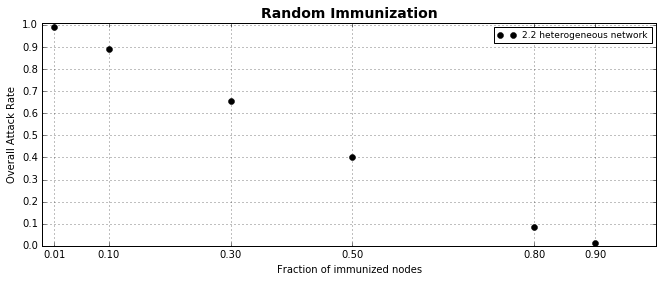

In [11]:
plt.figure(figsize=(11, 4))
plt.plot(ir,overall_attack_rate1,'ko')
plt.xticks(ir)
plt.yticks(np.array(range(11))/10)
plt.legend(['2.2 heterogeneous network'],prop={'size': 9})
plt.title('Random Immunization',fontsize=14, fontweight='bold')
plt.ylabel('Overall Attack Rate')
plt.xlabel('Fraction of immunized nodes')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.grid()
plt.show()

## <span style="color:#800000">2.3 - Generate a random Erdős–Rényi graph with the same size and density as the original social network. Repeat the experiment 2.2 above. Compare the results you obtain in this case and in the previous case, and explain the differences you observe.

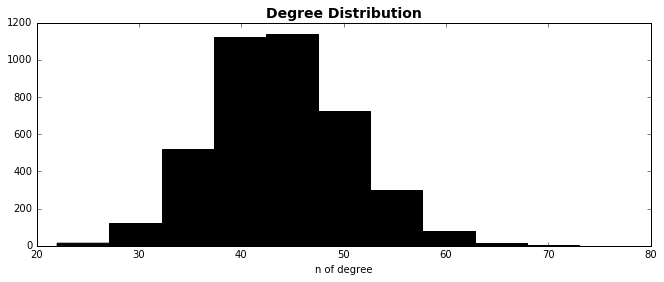

In [12]:
nedges = len(G.edges())
nnodes = len(G.nodes())
density = (2*nedges)/(nnodes*(nnodes-1))
G2 = nx.erdos_renyi_graph(nnodes, density)
plt.figure(figsize=(11, 4))
plt.hist(list(G2.degree().values()),10, color = (0,0,0,1))
plt.title('Degree Distribution', fontsize=14, fontweight='bold')
plt.xlabel('n of degree')
plt.show()

In [13]:
is_connected2 = []
overall_attack_rate2 = []
for r in ir:
    oar = 0
    c = []
    for i in range(n):
        SIR=SIRSimulator2(G2,beta,mu,r)
        results = [(status['is connected'], len(status["S"]), len(status['I']), len(status['R'])) 
                   for status in SIR.run(is_connected = True)]
        c += [results[0][0]]
        n_recovered_nodes = results[-1][-1]
        oar += n_recovered_nodes/len(G2.nodes())
    is_connected2 += [sum(c)/n]
    overall_attack_rate2 += [oar/n]

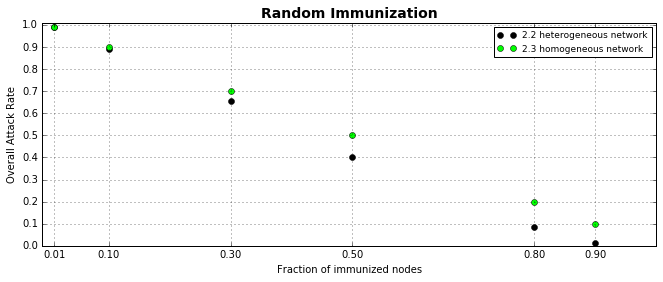

In [14]:
plt.figure(figsize=(11, 4))
plt.plot(ir,overall_attack_rate1,'ko')
plt.plot(ir,overall_attack_rate2,'o', color = (0,1,0,1))
plt.xticks(ir)
plt.yticks(np.array(range(11))/10)
plt.legend(['2.2 heterogeneous network','2.3 homogeneous network'],prop={'size': 9})
plt.title('Random Immunization',fontsize=14, fontweight='bold')
plt.ylabel('Overall Attack Rate')
plt.xlabel('Fraction of immunized nodes')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.grid()
plt.show()

In [15]:
print(is_connected)
print(is_connected2)

[0.84, 0.32, 0.02, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 0.86, 0.0]


### In an heterogeneous network the probability to remove many edges by removing n nodes is lower than in an homogenous network (since there are many nodes with only few edges). On the other hand to disconnect an heterogeneous network is easier with respect to an homogeneous one, meaning that there are nodes which cannot be infected anymore.

# <span style="color:#800000">PART 3: TARGETED VACCINATION STRATEGIES (12 points)

## <span style="color:#800000">3.1 - Imagine that you have a "budget" of M vaccination doses, with M < N, where N is the size of your network. That is, you can immunize a fraction r = M/N of nodes. You have studied above the effect of randomly immunizing the network nodes. Can you improve the performance of immunization, in terms of reduced overall attack rate, by means of "targeted" immunization? That is, by choosing the nodes to be immunized according to some specific strategy rather than choosing them at random. Provide an example of such a strategy, and test it in simulation, comparing the results you obtain with those of Part 2.2.

### In this case we can think of two main strategies: to remove the nodes with high betweenness centrality (to try to disconnect the graph) or to remove the nodes with many edges (so that they will be not able to infect their many neighbors).

In [16]:
from operator import itemgetter
dc = nx.degree_centrality(G)
bc = nx.betweenness_centrality(G)
cc = nx.closeness_centrality(G)
dc_nodes = [i for i,j in sorted(dc.items(), key=itemgetter(1), reverse = True)]
bc_nodes = [i for i,j in sorted(bc.items(), key=itemgetter(1), reverse = True)]
cc_nodes = [i for i,j in sorted(cc.items(), key=itemgetter(1), reverse = True)]

In [17]:
overall_attack_rate3d = []
overall_attack_rate3b = []
overall_attack_rate3c = []
for r in ir:
    nimmunized = int(r*len(G.nodes()))
    immunizedd = dc_nodes[:nimmunized]
    immunizedb = bc_nodes[:nimmunized]
    immunizedc = cc_nodes[:nimmunized]
    oard = 0
    oarb = 0
    oarc = 0
    for i in range(n):
        SIRd=SIRSimulator2(G,beta,mu)
        resultsd = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIRd.run(immunized=immunizedd)]
        n_recovered_nodesd = resultsd[-1][-1]
        oard += n_recovered_nodesd/len(G.nodes())
        
        SIRb=SIRSimulator2(G,beta,mu)
        resultsb = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIRb.run(immunized=immunizedb)]
        n_recovered_nodesb = resultsb[-1][-1]
        oarb += n_recovered_nodesb/len(G.nodes())
        
        SIRc=SIRSimulator2(G,beta,mu)
        resultsc = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIRc.run(immunized=immunizedc)]
        n_recovered_nodesc = resultsc[-1][-1]
        oarc += n_recovered_nodesc/len(G.nodes())
        
    overall_attack_rate3d += [oard/n]
    overall_attack_rate3b += [oarb/n]
    overall_attack_rate3c += [oarc/n]

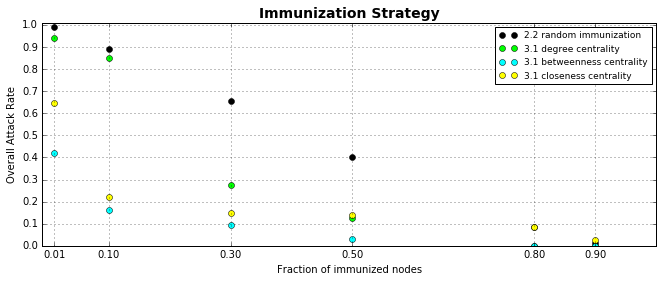

In [18]:
plt.figure(figsize=(11, 4))
plt.plot(ir,overall_attack_rate1,'ko')
plt.plot(ir,overall_attack_rate3d,'o', color = (0,1,0,1))
plt.plot(ir,overall_attack_rate3b,'o', color = (0,1,1,1))
plt.plot(ir,overall_attack_rate3c,'o', color = (1,1,0,1))
plt.xticks(ir)
plt.yticks(np.array(range(11))/10)
plt.legend(['2.2 random immunization','3.1 degree centrality','3.1 betweenness centrality', '3.1 closeness centrality'],prop={'size': 9})
plt.title('Immunization Strategy',fontsize=14, fontweight='bold')
plt.ylabel('Overall Attack Rate')
plt.xlabel('Fraction of immunized nodes')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.grid()
plt.show()

## <span style="color:#800000">3.2 - Now imagine that you still have a limited budget of M vaccination doses, but you cannot use information about the graph to decide how to use it. You can simulate a certain number of epidemics, without immunization, and use "historical" information on which nodes are infected (and when, and how often) to define your targeted immunization strategy. Design such a strategy and show its performance in simulation, comparing it to the random immunization of Part 2.2 and the targeted strategy you devised in Part 3.1 above.

### To estimate the nodes which are infecting more nodes, we can compute $\frac{(S->I)_t}{I_{t-1}}$. If a node appears many time in $I_t$ when $\frac{(S->I)_t}{I_{t-1}}$ is big, it means that the probability that it is infecting many node is high. Those nodes are also nodes easy to reach (since after a while the susceptible nodes are already turned in infected or recovered, in any case they cannot be infected anymore). Otherwise we can also try to immunize the nodes reached faster. 

In [19]:
n = 10000
nodes = []
for i in range(n):
    SIR=SIRSimulator(G,beta,mu)
    results = [[list(status['I']),list(status['S->I'])] for status in SIR.run()]
    infected = [i for i,si in results]
    si = [si for i,si in results]
    prop_I = [len(si[i])/len(infected[i-1]) for i in range(1,len(infected))]
    nodes += infected[np.argmax(prop_I)]

In [20]:
import collections
historical = collections.Counter(nodes)
historical_nodes = [i for i,j in sorted(historical.items(), key=itemgetter(1), reverse = True)]
print(len(historical_nodes))

3955


In [21]:
n = 1000
historical2 = {node: 0 for node in G.nodes()}
for i in range(n):
    left_nodes = G.nodes()
    SIR = SIRSimulator(G,beta,mu)
    si = [list(status['S->I']) for status in SIR.run()]
    for t in range(len(si)):
        left_nodes = set(left_nodes).difference(si[t])
        for node in si[t]:
            historical2[node] += t
    for node in left_nodes:
        historical2[node] += t+1

In [22]:
historical_nodes2 = [i for i,j in sorted(historical2.items(), key=itemgetter(1), reverse = False)]

In [23]:
n = 100
overall_attack_rate4_1 = []
overall_attack_rate4_2 = []
for r in ir:
    nimmunized = int(r*len(G.nodes()))
    immunized1 = historical_nodes[:nimmunized]
    immunized2 = historical_nodes2[:nimmunized]
    oar1 = 0
    oar2 = 0
    for i in range(n):
        SIR=SIRSimulator2(G,beta,mu)
        results = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIR.run(immunized=immunized1)]
        n_recovered_nodes = results[-1][-1]
        oar1 += n_recovered_nodes/len(G.nodes())
        
        SIR2=SIRSimulator2(G,beta,mu)
        results2 = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIR2.run(immunized=immunized2)]
        n_recovered_nodes2 = results2[-1][-1]
        oar2 += n_recovered_nodes2/len(G.nodes())
        
    overall_attack_rate4_1 += [oar1/n]
    overall_attack_rate4_2 += [oar2/n]

In [24]:
print(overall_attack_rate4_1)
print(overall_attack_rate4_2)

[0.8389551869274565, 0.693587521663778, 0.2776850705620203, 0.08513988611042335, 0.024513493438970045, 0.008148056449616243]
[0.6276751671205745, 0.22660559544441686, 0.1432285219113642, 0.12330774944293132, 0.08604852686308492, 0.02405298341173558]


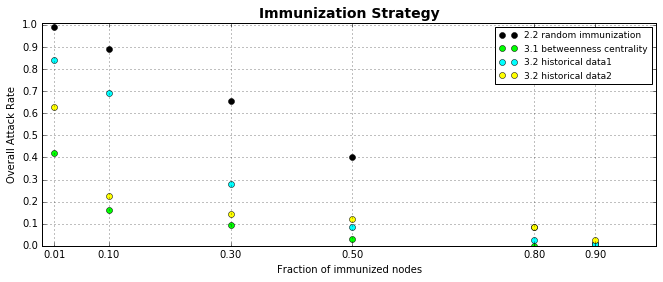

In [25]:
plt.figure(figsize=(11, 4))
plt.plot(ir,overall_attack_rate1,'ko')
plt.plot(ir,overall_attack_rate3b,'o', color = (0,1,0,1))
plt.plot(ir,overall_attack_rate4_1,'o', color = (0,1,1,1))
plt.plot(ir,overall_attack_rate4_2,'o', color = (1,1,0,1))
plt.xticks(ir)
plt.yticks(np.array(range(11))/10)
plt.legend(['2.2 random immunization','3.1 betweenness centrality','3.2 historical data1', '3.2 historical data2'],
           prop={'size': 9})
plt.title('Immunization Strategy',fontsize=14, fontweight='bold')
plt.ylabel('Overall Attack Rate')
plt.xlabel('Fraction of immunized nodes')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.grid()
plt.show()

### for r<0.30 the second method is better than the first one. 

## <span style="color:#800000">3.3 - Finally, imagine that you have limited information about the social network: you are given a set of K nodes (K << N, say K ~ 10% of the network) and for those K nodes you are given a list of their neighbors. Design a targeted immunization strategy that makes use of this information, and test its performance in simulation.

### Also in this case we can try to compute the betweenness centrality and remove the nodes where it is higher.

In [26]:
nseed_nodes = int(0.1*len(G.nodes()))
seed_nodes = np.random.permutation(G.nodes())[:nseed_nodes]
edges = [edge for edge in G.edges() if len(set(seed_nodes).intersection(edge))] 
small_graph = nx.Graph(edges)

In [27]:
print(len(small_graph.nodes()))

3332


In [28]:
bc = nx.betweenness_centrality(small_graph)
bc_nodes2 = [i for i,j in sorted(bc.items(), key=itemgetter(1), reverse = True)]

In [29]:
overall_attack_rate5 = []
for r in ir:
    nimmunized = int(r*len(G.nodes()))
    immunized = bc_nodes2[:nimmunized]
    oar = 0
    for i in range(n):
        SIR=SIRSimulator2(G,beta,mu)
        results = [(len(status["S"]), len(status['I']), len(status['R'])) for status in SIR.run(immunized=immunized)]
        n_recovered_nodes = results[-1][-1]
        oar += n_recovered_nodes/len(G.nodes())
    overall_attack_rate5 += [oar/n]

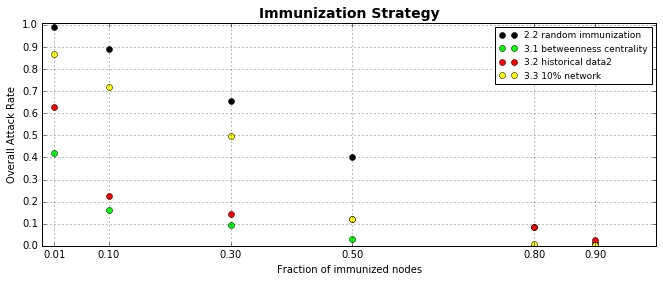

In [30]:
plt.figure(figsize=(11, 4))
plt.plot(ir,overall_attack_rate1, 'ko')
plt.plot(ir,overall_attack_rate3b,'o', color = (0,1,0,1))
plt.plot(ir,overall_attack_rate4_2,'o', color = (1,0,0,1))
plt.plot(ir,overall_attack_rate5,'o', color = (1,1,0,1))
plt.xticks(ir)
plt.yticks(np.array(range(11))/10)
plt.legend(['2.2 random immunization','3.1 betweenness centrality','3.2 historical data2','3.3 10% network'],prop={'size': 9})
plt.title('Immunization Strategy',fontsize=14, fontweight='bold')
plt.ylabel('Overall Attack Rate')
plt.xlabel('Fraction of immunized nodes')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)
plt.grid()
plt.show()